In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diseases-and-symptoms-dataset/Final_Augmented_dataset_Diseases_and_Symptoms.csv
/kaggle/input/disease-symptom-description-dataset/symptom_Description.csv
/kaggle/input/disease-symptom-description-dataset/Symptom-severity.csv
/kaggle/input/disease-symptom-description-dataset/symptom_precaution.csv
/kaggle/input/disease-symptom-description-dataset/dataset.csv


In [2]:
df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/dataset.csv')


In [3]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


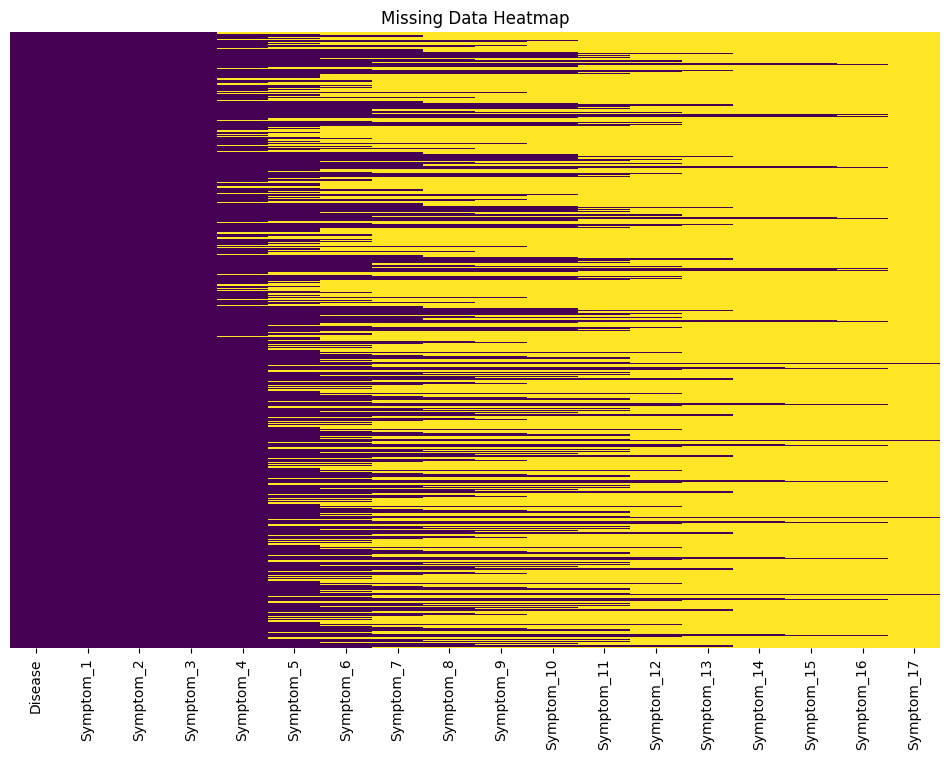

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the DataFrame into a boolean mask (True for missing values)
missing_data = df.isnull()

# Create a heatmap of missing data
plt.figure(figsize=(12, 8))
sns.heatmap(missing_data, cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

***PURPLE FOR NON_MISSING VALUES AND YELLOW FOR MISSING VALUES***

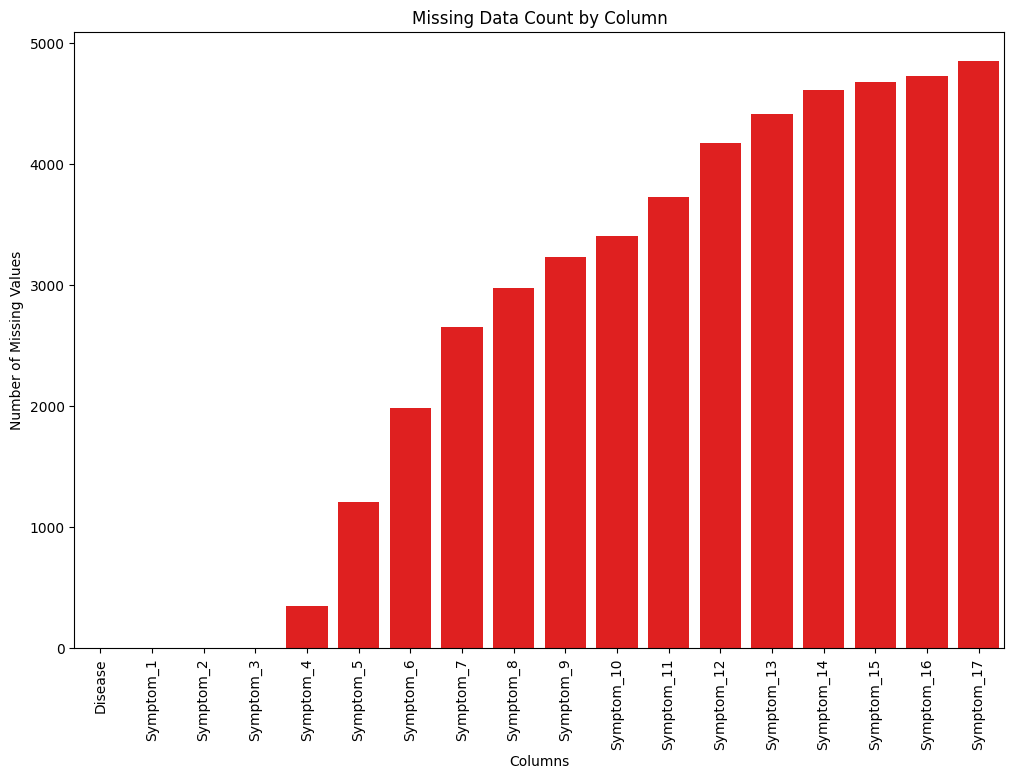

In [6]:
# Count the number of missing values in each column
missing_count = df.isnull().sum()

# Create a bar plot for missing values
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_count.index, y=missing_count.values, color='red')
plt.title('Missing Data Count by Column')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()


BAR CHART SHOWING MISSING VALUES IN EACH COLUMN

In [7]:
# Replace NaNs with a placeholder
df.fillna('none', inplace=True)

**EXTRACT UNIQUE SYMPTOMS**

In [8]:

symptom_cols = [f'Symptom_{i}' for i in range(1, 18)]
all_symptoms = df[symptom_cols].values.flatten()
unique_symptoms = pd.Series(all_symptoms).dropna().unique()
unique_symptoms = [sym for sym in unique_symptoms if sym != 'none']

In [9]:
# Create empty binary matrix
binary_matrix = pd.DataFrame(0, index=df.index, columns=unique_symptoms)

# Fill binary matrix: set 1 where symptom is present
for i, row in df.iterrows():
    symptoms_present = row[symptom_cols].values
    for s in symptoms_present:
        if s != 'none':
            binary_matrix.loc[i, s] = 1

In [10]:
binary_matrix['Disease'] = df['Disease']

In [11]:
#CONVERTED DATASET
binary_matrix.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,...,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Disease
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


In [12]:
binary_matrix.to_csv('binary_symptom_dataset.csv', index=False)

<Axes: title={'center': 'Top 20 Most Common Symptoms'}>

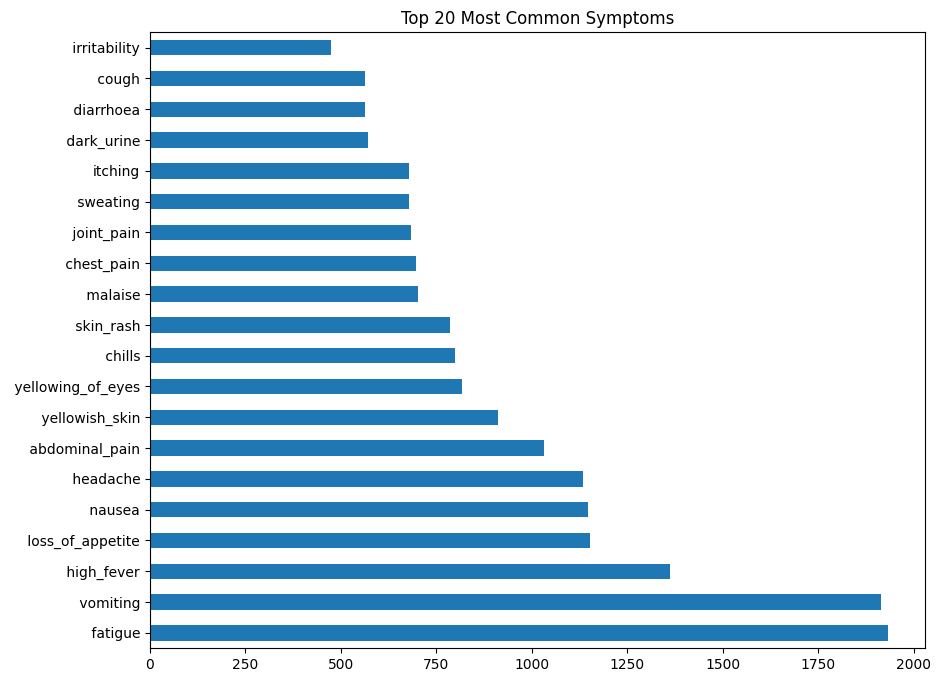

In [13]:
#top 20 most common symptoms 
symptom_counts = binary_matrix.drop(columns=['Disease']).sum().sort_values(ascending=False)
symptom_counts.head(20).plot(kind='barh', figsize=(10,8), title='Top 20 Most Common Symptoms')

In [14]:
#checking for imbalance
binary_matrix['Disease'].value_counts()

Disease
Fungal infection                           120
Hepatitis C                                120
Hepatitis E                                120
Alcoholic hepatitis                        120
Tuberculosis                               120
Common Cold                                120
Pneumonia                                  120
Dimorphic hemmorhoids(piles)               120
Heart attack                               120
Varicose veins                             120
Hypothyroidism                             120
Hyperthyroidism                            120
Hypoglycemia                               120
Osteoarthristis                            120
Arthritis                                  120
(vertigo) Paroymsal  Positional Vertigo    120
Acne                                       120
Urinary tract infection                    120
Psoriasis                                  120
Hepatitis D                                120
Hepatitis B                                120
Aller

**Bayesian smoothing formula**


P(symptom present in disease) = {count(symptom in disease) + (alpha)}/{(total patients in disease) + (alpha) + (beta)}

In [15]:
import pandas as pd

# Assuming your binary_matrix (symptoms presence) and df['Disease'] are already defined:
# Add the disease column to binary_matrix for grouping
binary_matrix_with_disease = binary_matrix.copy()
binary_matrix_with_disease['Disease'] = df['Disease'].values

# Disease-wise symptom counts
disease_symptom_counts = binary_matrix_with_disease.groupby('Disease').sum()


# Total patients per disease (should be 120 each)
disease_patient_counts = binary_matrix_with_disease.groupby('Disease').size()
print(disease_patient_counts)

# Disease-level smoothed probabilities
alpha = 1   # Prior count (you can tune these)
beta = 5    # Higher beta means more smoothing for extremely rare symptoms

disease_smoothed_probs = (disease_symptom_counts + alpha).div(disease_patient_counts + alpha + beta, axis=0)

# Example: Probability of each symptom in each disease after smoothing
print(disease_smoothed_probs.head())

Disease
(vertigo) Paroymsal  Positional Vertigo    120
AIDS                                       120
Acne                                       120
Alcoholic hepatitis                        120
Allergy                                    120
Arthritis                                  120
Bronchial Asthma                           120
Cervical spondylosis                       120
Chicken pox                                120
Chronic cholestasis                        120
Common Cold                                120
Dengue                                     120
Diabetes                                   120
Dimorphic hemmorhoids(piles)               120
Drug Reaction                              120
Fungal infection                           120
GERD                                       120
Gastroenteritis                            120
Heart attack                               120
Hepatitis B                                120
Hepatitis C                                120
Hepat

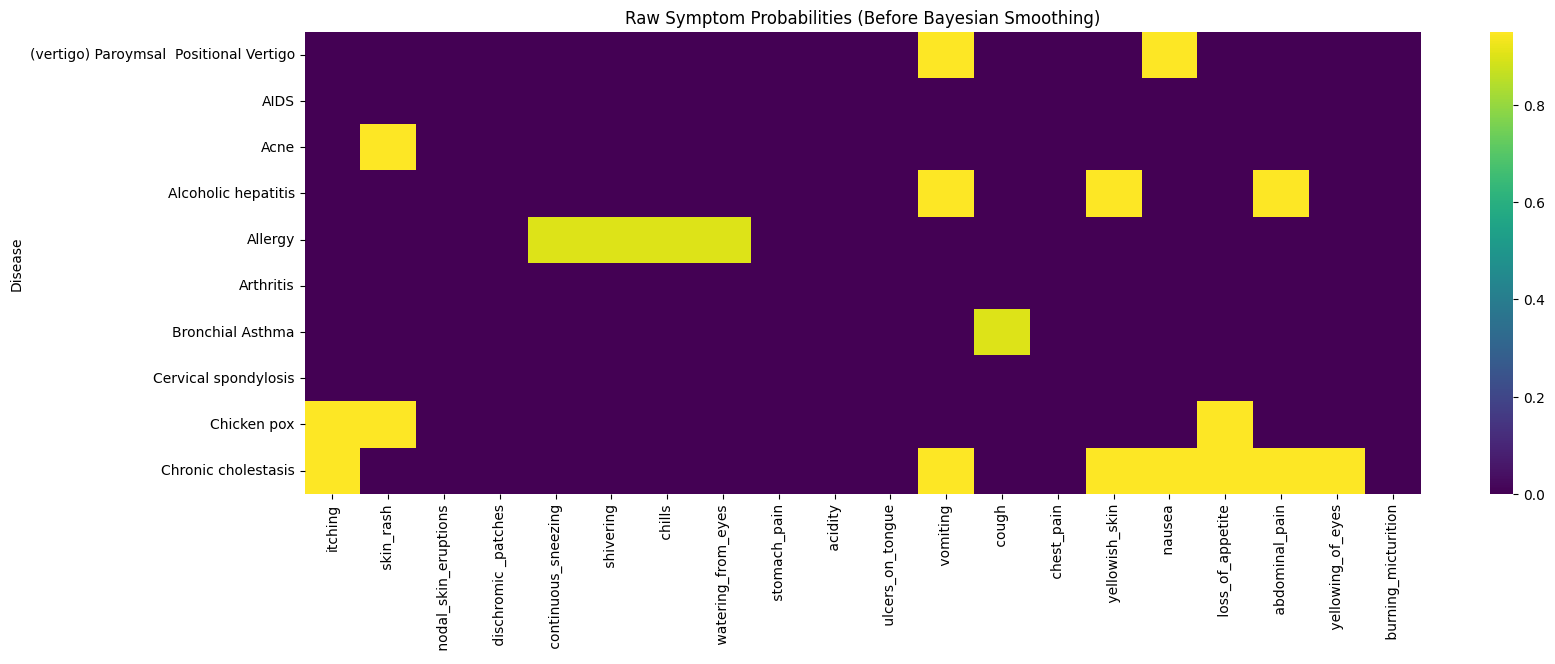

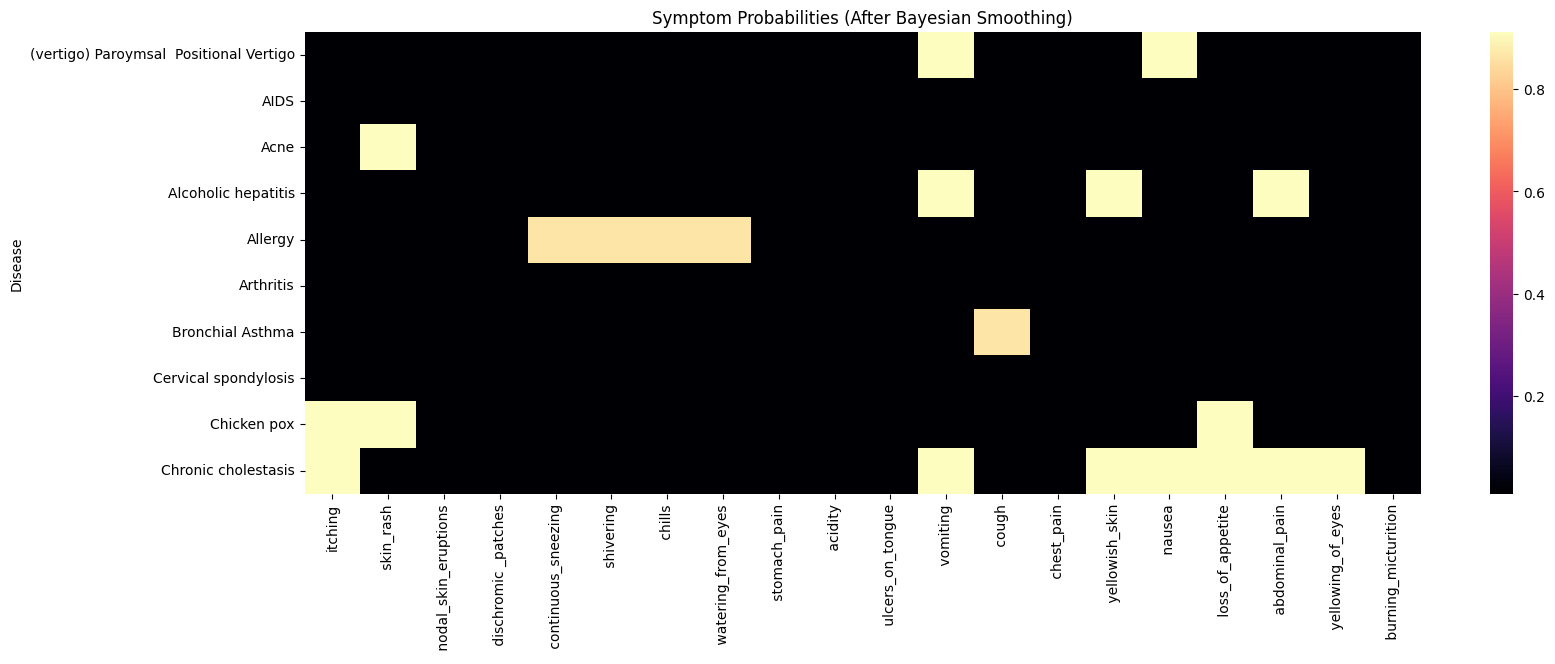

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Before smoothing (raw probability)
disease_raw_probs = disease_symptom_counts.div(disease_patient_counts, axis=0)

# Plot heatmap for a subset (first 10 diseases, first 20 symptoms)
plt.figure(figsize=(18, 6))
sns.heatmap(disease_raw_probs.iloc[:10, :20], cmap='viridis')
plt.title("Raw Symptom Probabilities (Before Bayesian Smoothing)")
plt.show()

# After smoothing
plt.figure(figsize=(18, 6))
sns.heatmap(disease_smoothed_probs.iloc[:10, :20], cmap='magma')
plt.title("Symptom Probabilities (After Bayesian Smoothing)")
plt.show()

In [17]:
X_binary = binary_matrix.drop(columns=['Disease'])
y = binary_matrix['Disease']

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True)
tfidf_matrix = tfidf_transformer.fit_transform(X_binary.values)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=X_binary.columns, index=X_binary.index)

In [19]:
tfidf_df['Disease'] = y

In [20]:
print(tfidf_df.head())

    itching   skin_rash   nodal_skin_eruptions   dischromic _patches  \
0  2.980646    2.833039               4.809919              4.809919   
1  0.000000    2.833039               4.809919              4.809919   
2  2.980646    0.000000               4.809919              4.809919   
3  2.980646    2.833039               0.000000              4.809919   
4  2.980646    2.833039               4.809919              0.000000   

    continuous_sneezing   shivering   chills   watering_from_eyes  \
0                   0.0         0.0      0.0                  0.0   
1                   0.0         0.0      0.0                  0.0   
2                   0.0         0.0      0.0                  0.0   
3                   0.0         0.0      0.0                  0.0   
4                   0.0         0.0      0.0                  0.0   

    stomach_pain   acidity  ...   foul_smell_of urine  \
0            0.0       0.0  ...                   0.0   
1            0.0       0.0  ...       

Community 1: [' blood_in_sputum', ' yellowing_of_eyes', ' nausea', ' dark_urine', ' dischromic _patches', ' coma', ' passage_of_gases', ' pain_behind_the_eyes', ' mucoid_sputum', ' dehydration', ' diarrhoea', ' nodal_skin_eruptions', 'itching', ' joint_pain', ' yellowish_skin', ' fluid_overload', ' back_pain', ' headache', ' acute_liver_failure', ' red_spots_over_body', ' family_history', ' weakness_of_one_body_side', ' muscle_pain', ' chills', ' sunken_eyes', ' stomach_bleeding', ' receiving_unsterile_injections', ' vomiting', ' history_of_alcohol_consumption', ' altered_sensorium', ' loss_of_appetite', ' spinning_movements', ' unsteadiness', ' red_sore_around_nose', ' internal_itching', ' mild_fever', ' blister', ' loss_of_balance', ' breathlessness', ' toxic_look_(typhos)', ' belly_pain', ' yellow_crust_ooze', ' abdominal_pain', ' receiving_blood_transfusion', ' swelling_of_stomach', ' yellow_urine', ' malaise', ' swelled_lymph_nodes', ' constipation', ' skin_rash', ' distention_of_

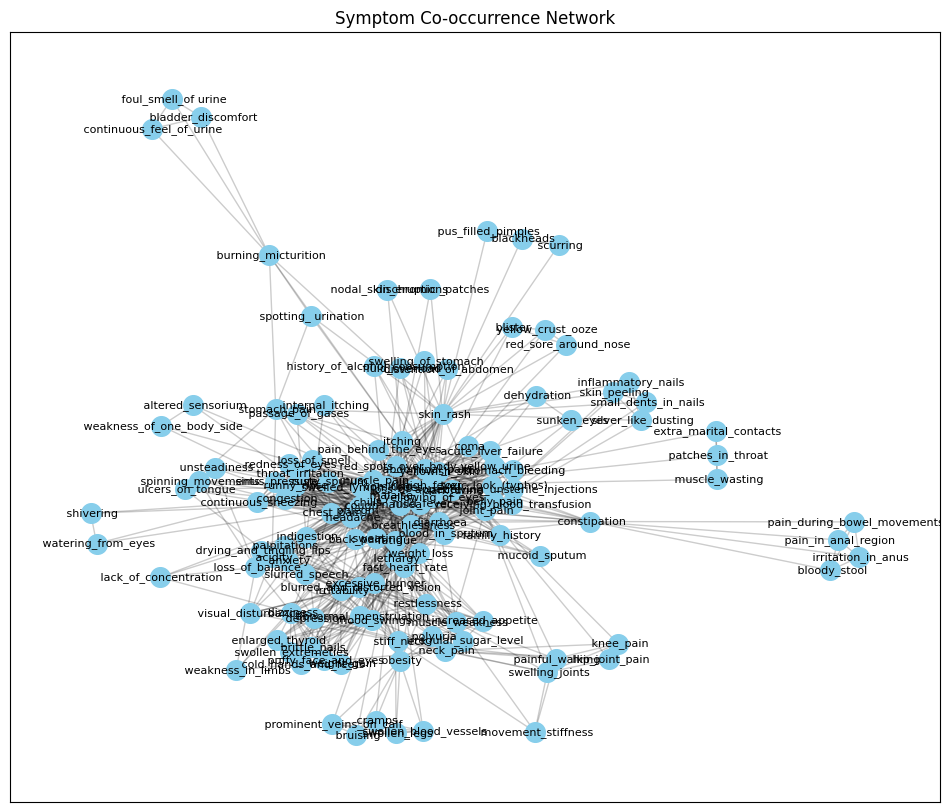

In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming `binary_matrix` has columns as symptoms and rows as patients with 1/0 presence
symptom_cols = [col for col in binary_matrix.columns if col != 'Disease']

# Create co-occurrence matrix
co_occurrence = pd.DataFrame(0, index=symptom_cols, columns=symptom_cols)

for idx, row in binary_matrix[symptom_cols].iterrows():
    present_symptoms = row[row == 1].index.tolist()
    for s1 in present_symptoms:
        for s2 in present_symptoms:
            if s1 != s2:
                co_occurrence.loc[s1, s2] += 1

# Build graph from co-occurrence
G = nx.from_pandas_adjacency(co_occurrence)

# Detect communities
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G))

# Print detected symptom clusters
for idx, community in enumerate(communities):
    print(f"Community {idx+1}: {list(community)}")

# Optional: Visualize communities
plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx_nodes(G, pos, node_size=200, node_color="skyblue")
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Symptom Co-occurrence Network")
plt.show()

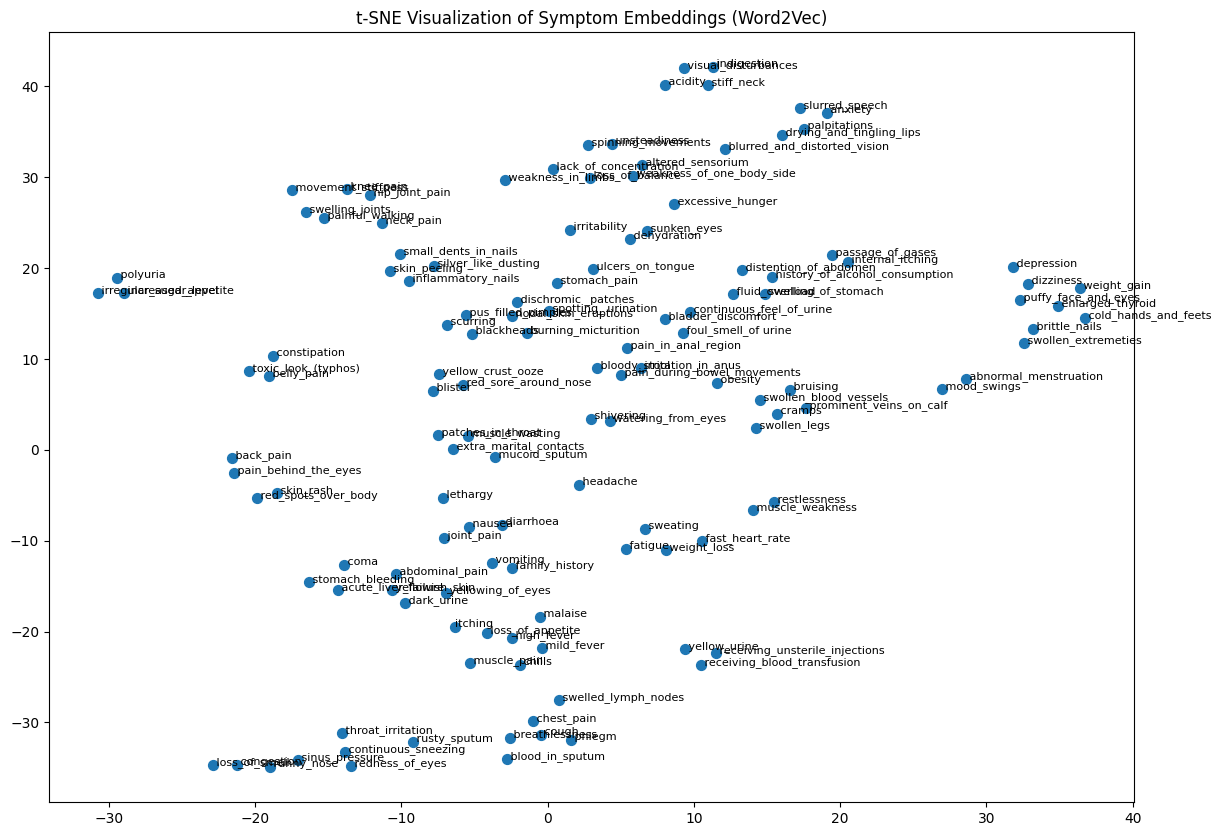

In [22]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Prepare symptom lists for Word2Vec training
symptom_lists = binary_matrix.apply(lambda row: [symptom for symptom, val in row.items() if val == 1], axis=1).tolist()

# Train Word2Vec model (you can increase vector_size to 100 if memory allows)
word2vec_model = Word2Vec(sentences=symptom_lists, vector_size=50, window=5, min_count=1, workers=4, epochs=100)

# Create embeddings array
symptom_names = list(word2vec_model.wv.key_to_index.keys())
symptom_vectors = np.array([word2vec_model.wv[s] for s in symptom_names])

# Visualize using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=3000)
embedding_2d = tsne.fit_transform(symptom_vectors)

# Plot
plt.figure(figsize=(14, 10))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=50)

for i, symptom in enumerate(symptom_names):
    plt.annotate(symptom, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=8)

plt.title("t-SNE Visualization of Symptom Embeddings (Word2Vec)")
plt.show()

In [23]:
from sklearn.model_selection import train_test_split

X = binary_matrix .drop(columns=['Disease'])  # drop the target column
y = binary_matrix ['Disease']                 # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y,shuffle=True)

**BASELINE MODEl BEFORE HYPER-PARAMETER TUNING**

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Baseline model
base_rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
base_rfc.fit(X_train, y_train)

# Predictions
base_preds = base_rfc.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, base_preds))
print(classification_report(y_test, base_preds))

Baseline Accuracy: 1.0
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.00      1.00      1.00        24
    

feature importance visualization

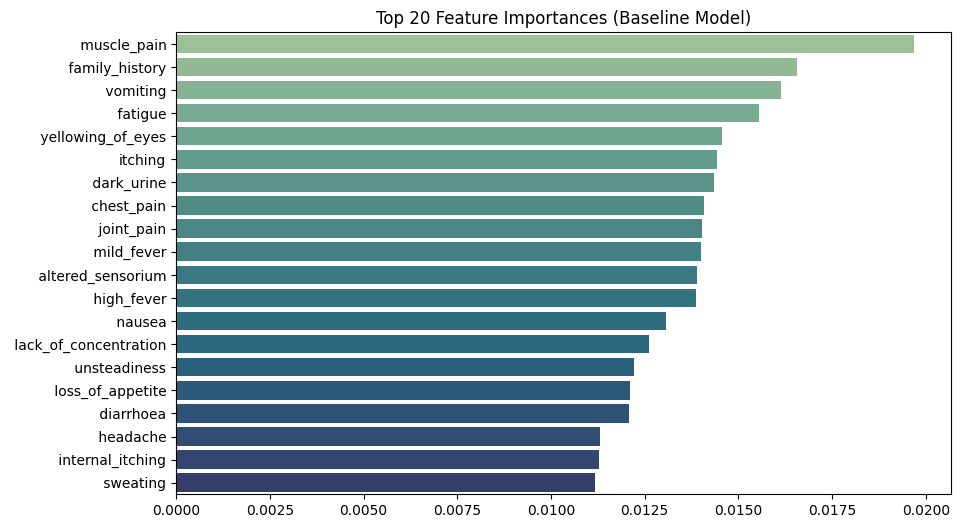

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

importances = pd.Series(base_rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index, palette='crest')
plt.title("Top 20 Feature Importances (Baseline Model)")
plt.show()

In [26]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(rfc, param_distributions=param_dist, 
                                   cv=3, scoring='accuracy', verbose=2, 
                                   n_iter=20, n_jobs=-1)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [27]:
results_df = pd.DataFrame(random_search.cv_results_)
top_results = results_df[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False).head()
display(top_results)

,mean_test_score,params
0,1.0,"{'n_estimators': 200, 'min_samples_leaf': 1, '..."
1,1.0,"{'n_estimators': 300, 'min_samples_leaf': 2, '..."
18,1.0,"{'n_estimators': 300, 'min_samples_leaf': 4, '..."
17,1.0,"{'n_estimators': 200, 'min_samples_leaf': 2, '..."
16,1.0,"{'n_estimators': 200, 'min_samples_leaf': 4, '..."


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


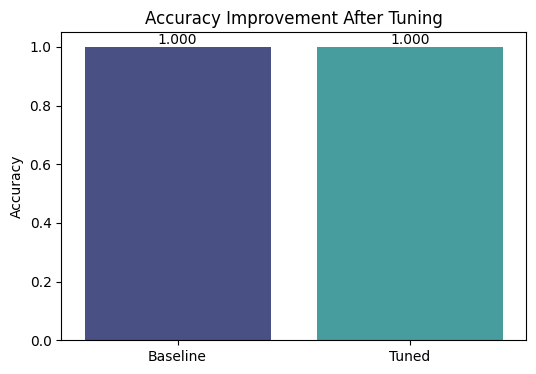

In [28]:
tuned_preds = best_model.predict(X_test)
from sklearn.metrics import accuracy_score

base_acc = accuracy_score(y_test, base_preds)
tuned_acc = accuracy_score(y_test, tuned_preds)

plt.figure(figsize=(6,4))
sns.barplot(x=['Baseline', 'Tuned'], y=[base_acc, tuned_acc], palette='mako')
plt.title("Accuracy Improvement After Tuning")
plt.ylabel("Accuracy")
for i, val in enumerate([base_acc, tuned_acc]):
    plt.text(i, val + 0.01, f"{val:.3f}", ha='center')
plt.show()

In [29]:
from sklearn.metrics import f1_score, log_loss

f1_baseline = f1_score(y_test, base_preds, average='macro')
f1_tuned = f1_score(y_test, tuned_preds, average='macro')
print(f"Baseline F1: {f1_baseline}, Tuned F1: {f1_tuned}")

Baseline F1: 1.0, Tuned F1: 1.0


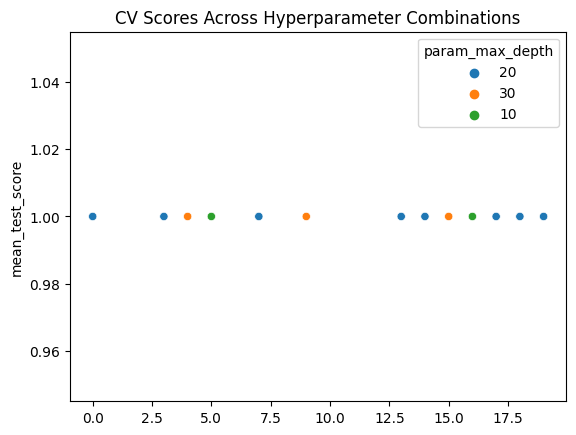

In [30]:
cv_results = pd.DataFrame(random_search.cv_results_)
sns.scatterplot(x=range(len(cv_results)), y=cv_results['mean_test_score'], hue=cv_results['param_max_depth'])
plt.title("CV Scores Across Hyperparameter Combinations")
plt.show()

In [31]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(best_model, cv=3)
calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=20,
                                                        n_estimators=200,
                                                        random_state=42))

In [32]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_calibrated = calibrated_model.predict(X_test)
calibrated_accuracy = accuracy_score(y_test, y_pred_calibrated)

print("Accuracy after calibration:", calibrated_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_calibrated))

Accuracy after calibration: 1.0
Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.00  

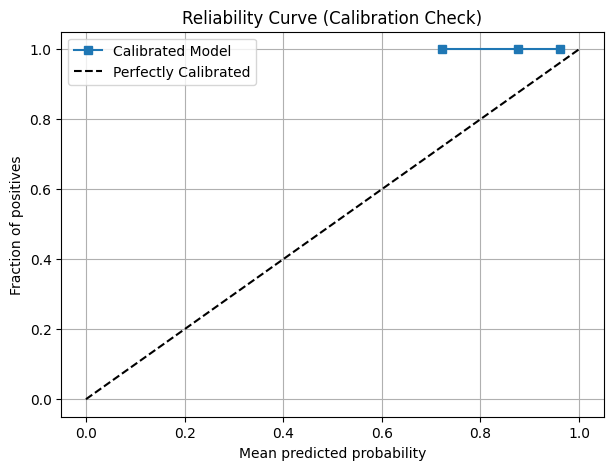

In [33]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

y_prob_calibrated = calibrated_model.predict_proba(X_test)
# Take probabilities of the predicted class
max_probs = y_prob_calibrated.max(axis=1)

fraction_of_positives, mean_predicted_value = calibration_curve((y_test == y_pred_calibrated).astype(int), max_probs, n_bins=10)

plt.figure(figsize=(7, 5))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrated Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability Curve (Calibration Check)")
plt.legend()
plt.grid()
plt.show()